# Interactive Pixel and Patch EDA
This notebook explores what the frames, pixels, and patches of the frames look like over time. 

It loads the baseline files, displays example frames, descriptive stats, and plots the timecourse of a pixel and a patch.

Author: Brynn Harris-Shanks

## Set-up
### Imports

In [1]:

from pathlib import Path
import sys
import yaml
import os

# Locate repo root
repo_root = next(
    p for p in (Path.cwd(), *Path.cwd().parents)
    if (p / "config" / "config.yml").exists()
)

# Add code directory to import path
code_dir = repo_root / "code"
if str(code_dir) not in sys.path:
    sys.path.insert(0, str(code_dir))

# Load config
config_path = repo_root / "config" / "config.yml"
config = yaml.safe_load(config_path.read_text(encoding="utf-8"))

In [2]:
from IPython.display import display
from IPython import get_ipython
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.colors import TwoSlopeNorm
from matplotlib.patches import Rectangle
import numpy as np
from utils import helper_functions as hf

In [3]:
# Inline backend
USE_WIDGET = False
ipy = get_ipython()
backend_mode = "inline"
if ipy is not None:
    try:
        ipy.run_line_magic("matplotlib", "inline")
    except Exception:
        pass
print(f"Matplotlib backend: {matplotlib.get_backend()} | mode={backend_mode}")

# Core paths
deriv_root = repo_root / config["paths"]["preprocessing"]
subjects = config["subjects"]["all"]
sample_subject = config["subjects"]["default"]
data_mode = "zscore"
sample_session_idx = 2
sample_frame_idx = 0

Matplotlib backend: inline | mode=inline


### Load Baseline Data

Iterates over all subjects, loads all baseline sessions from either:
- baseline_only if data_mode == "raw", or
- baseline_only_normalized/{data_mode} (zscore or mean_divide)


Prints dataset summaries (session counts, frame counts, shapes, value ranges).

In [4]:
for subject in subjects:
    data_output_dir = deriv_root / subject  # subject-specific output folder
    data_output_dir.mkdir(parents=True, exist_ok=True)
    if data_mode == "raw":
        baseline_output_dir = os.path.join(data_output_dir, "baseline_only")
    else:
        baseline_output_dir = os.path.join(
            data_output_dir, f"baseline_only_normalized/{data_mode}"
        )
    # Load all baseline sessions
    baseline_sessions = hf.load_saved_baseline_sessions(baseline_output_dir)

    # Print summary
    if len(baseline_sessions) > 0:
        print(f"\nBaseline Data Summary:{subject} ({data_mode})")
        print(f"  Total sessions: {len(baseline_sessions)}")
        total_frames = sum(s["frames"].shape[0] for s in baseline_sessions)
        print(f"  Total baseline frames: {total_frames:,}")

        spatial_shapes = [s["frames"].shape[1:] for s in baseline_sessions]
        unique_shapes = set(spatial_shapes)
        print(f"  Spatial dimensions: {unique_shapes}")

        # Show frame count distribution
        frame_counts = [s["frames"].shape[0] for s in baseline_sessions]
        print(
            f"  Frames per session: min={min(frame_counts)}, max={max(frame_counts)}, "
            f"mean={np.mean(frame_counts):.0f}, std={np.std(frame_counts):.0f}"
        )

        # first session
        if len(baseline_sessions) > 0:
            first_session = baseline_sessions[0]
            print(f"\n  First session ({first_session['session_id']}):")
            print(f"    Frames: {first_session['frames'].shape[0]}")
            print(f"    Shape: {first_session['frames'].shape}")
            print(f"    Dtype: {first_session['frames'].dtype}")
            print(
                f"Value range: [{first_session['frames'].min():.2f}, {first_session['frames'].max():.2f}]"
            )


Baseline Data Summary:secundo (zscore)
  Total sessions: 34
  Total baseline frames: 14,043
  Spatial dimensions: {(107, 128), (132, 128), (101, 128), (112, 128), (96, 128), (91, 128), (122, 128)}
  Frames per session: min=1, max=906, mean=413, std=202

  First session (Se01072020):
    Frames: 526
    Shape: (526, 101, 128)
    Dtype: float32
Value range: [-4.49, 10.65]

Baseline Data Summary:gus (zscore)
  Total sessions: 13
  Total baseline frames: 5,838
  Spatial dimensions: {(132, 128), (101, 128), (112, 128), (96, 128), (81, 128), (122, 128)}
  Frames per session: min=258, max=549, mean=449, std=123

  First session (Gu03092020):
    Frames: 539
    Shape: (539, 112, 128)
    Dtype: float32
Value range: [-4.97, 11.45]


---

### Load Normalized Baseline Frames

First loads raw sessions for sample_subject to pick a session_id. 

Then loads normalized frames for that one session with:hf.load_saved_session_frames(..., "mean_divide")


Selects one frame: frame = mean_frames[sample_frame_idx]

In [5]:
# summary loop
for subject in subjects:
    data_output_dir = deriv_root / subject
    mode_dir = (
        data_output_dir / "baseline_only"
        if data_mode == "raw"
        else data_output_dir / "baseline_only_normalized" / data_mode
    )
    subject_sessions = hf.load_saved_baseline_sessions(str(mode_dir))  # <- not baseline_sessions

# sample session load (always from sample_subject)
sample_raw_dir = deriv_root / sample_subject / "baseline_only"
sample_sessions = hf.load_saved_baseline_sessions(str(sample_raw_dir))

if not (0 <= sample_session_idx < len(sample_sessions)):
    raise ValueError(f"sample_session_idx out of range [0, {len(sample_sessions)-1}]")

sample_session = sample_sessions[sample_session_idx]
mean_frames = hf.load_saved_session_frames(
    deriv_root,
    sample_subject,
    sample_session["session_id"],
    data_mode,
)

if not (0 <= sample_frame_idx < mean_frames.shape[0]):
    raise ValueError(
        f"sample_frame_idx={sample_frame_idx} out of range [0, {mean_frames.shape[0] - 1}]"
    )

frame = mean_frames[sample_frame_idx]


---
## Frame, Pixel, Patch Analysis

#### Sample Frame
##### heatmap with interactive cursor coordinates `(y, x)`

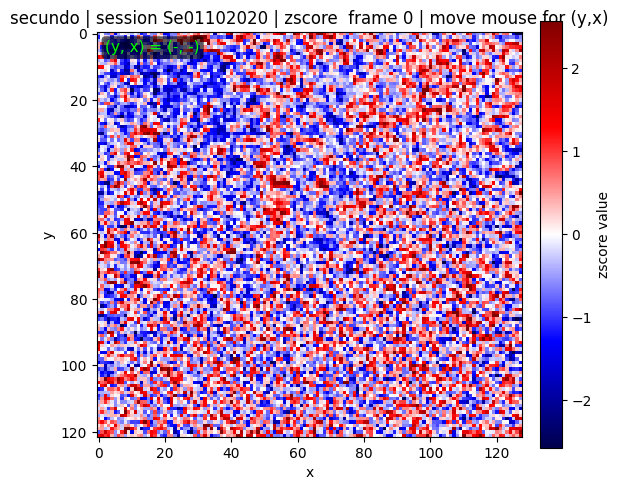

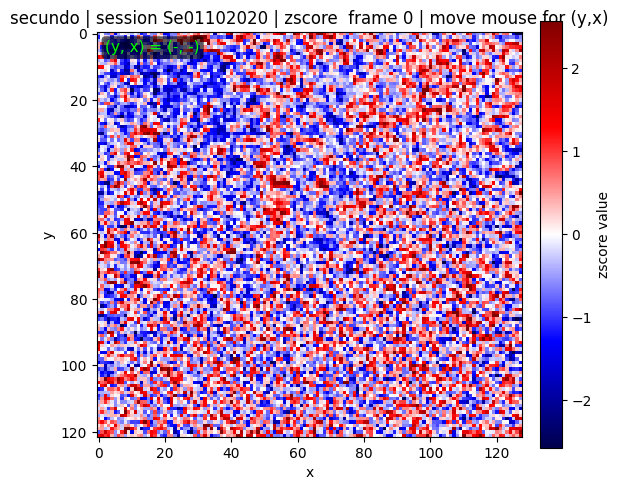

In [6]:
# symmetric limits around 0 for diverging display
abs_lim = float(np.percentile(np.abs(frame), 99.0))
if abs_lim <= 1e-8:
    abs_lim = 1.0
norm = TwoSlopeNorm(vmin=-abs_lim, vcenter=0.0, vmax=abs_lim)

fig, ax = plt.subplots(figsize=(6, 6))
im = ax.imshow(frame, cmap="seismic", norm=norm)
cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label( f"{data_mode} value", rotation=90)
ax.set_title(
    f"{sample_subject} | session {sample_session['session_id']} | {data_mode}  frame {sample_frame_idx} | move mouse for (y,x)"
)
ax.set_xlabel("x")
ax.set_ylabel("y")

coord_text = ax.text(
    0.02,
    0.98,
    "(y, x) = (-, -)",
    transform=ax.transAxes,
    ha="left",
    va="top",
    fontsize=11,
    color="lime",
    bbox=dict(
        facecolor="black", alpha=0.6, edgecolor="none", boxstyle="round,pad=0.25"
    ),
)

def on_move(event):
    if event.inaxes != ax or event.xdata is None or event.ydata is None:
        return
    x = int(round(event.xdata))
    y = int(round(event.ydata))
    h, w = frame.shape
    if 0 <= x < w and 0 <= y < h:
        coord_text.set_text(f"(y, x) = ({y}, {x})")
        fig.canvas.draw_idle()


# show coordinates in status/toolbar when supported
ax.format_coord = lambda x, y: (
    f"x={int(round(x))}, y={int(round(y))}" if (x is not None and y is not None) else ""
)

_ = fig.canvas.mpl_connect("motion_notify_event", on_move)
plt.tight_layout()
explorer_fig = fig

# inline-only display (avoid ipywidgets frontend requirements in VS Code)
display(fig)
plt.show()


##### full timecourse video across frames (saved as MP4 or GIF)

In [7]:
ref_frame = mean_frames[sample_frame_idx]
abs_lim = float(np.percentile(np.abs(ref_frame), 99.0))
if abs_lim <= 1e-8:
    abs_lim = 1.0
norm = TwoSlopeNorm(vmin=-abs_lim, vcenter=0.0, vmax=abs_lim)

fig, ax = plt.subplots(figsize=(6, 6))
im = ax.imshow(mean_frames[0], cmap="seismic", norm=norm)
cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label(f"{data_mode}  value", rotation=90)

title = ax.set_title(
    f"{sample_subject} | session {sample_session['session_id']} | {data_mode}  frame 0"
)
ax.set_xlabel("x")
ax.set_ylabel("y")

T = mean_frames.shape[0]
image_data = mean_frames

def update_frame_in_video(i):
    im.set_data(image_data[i])
    title.set_text(
        f"{sample_subject} | session {sample_session['session_id']} | {data_mode}  frame {i}"
    )
    return (im,)

ani = animation.FuncAnimation(
    fig, update_frame_in_video, frames=T, interval=100, blit=False, repeat=False
)

out_dir = Path("derivatives") / "videos"
out_dir.mkdir(parents=True, exist_ok=True)
base = f"{sample_subject}_session-{sample_session['session_id']}_{data_mode} "

mp4_path = out_dir / f"{base}.mp4"
gif_path = out_dir / f"{base}.gif"

saved = None
try:
    writer = animation.FFMpegWriter(fps=10, bitrate=1800)
    ani.save(str(mp4_path), writer=writer, dpi=150)
    saved = mp4_path
except FileNotFoundError:
    print("ffmpeg not found; saving GIF instead...")
    writer = animation.PillowWriter(fps=10)
    ani.save(str(gif_path), writer=writer, dpi=120)
    saved = gif_path

plt.close(fig)
print(f"Saved: {saved}")

ffmpeg not found; saving GIF instead...
Saved: derivatives\videos\secundo_session-Se01102020_zscore .gif


#### Sample pixel
##### timecourse plot (line + color-coded scatter + selected frame markers)

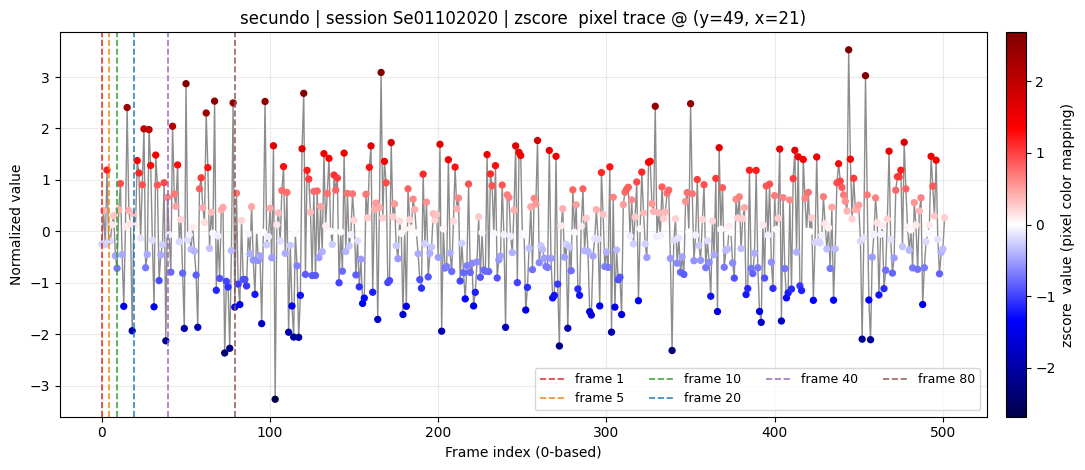

In [8]:
# plot one pixel over time (f"{data_mode}  normalization) for a sample baseline acquisition
T, H, W = mean_frames.shape
y = 49
x = 21  # slightly left of center

pixel_ts = mean_frames[:, y, x]
t = np.arange(T)

# symmetric color limits around 0 from robust percentile of this pixel trace
abs_lim = float(np.percentile(np.abs(pixel_ts), 99.0))
if abs_lim <= 1e-8:
    abs_lim = 1.0
norm = TwoSlopeNorm(vmin=-abs_lim, vcenter=0.0, vmax=abs_lim)

fig, ax = plt.subplots(figsize=(11, 4.8))
ax.plot(t, pixel_ts, color="black", linewidth=1.0, alpha=0.45, zorder=1)
sc = ax.scatter(t, pixel_ts, c=pixel_ts, cmap="seismic", norm=norm, s=18, zorder=2)

marker_frames_1based = [1, 5, 10, 20, 40, 80]
marker_colors = [
    "tab:red",
    "tab:orange",
    "tab:green",
    "tab:blue",
    "tab:purple",
    "tab:brown",
]

for f, c in zip(marker_frames_1based, marker_colors, strict =False):
    idxf = f - 1  # convert to 0-based index for plotting
    if 0 <= idxf < T:
        ax.axvline(
            idxf, linestyle="--", linewidth=1.2, color=c, alpha=0.9, label=f"frame {f}"
        )

cbar = fig.colorbar(sc, ax=ax, fraction=0.04, pad=0.02)
cbar.set_label(f"{data_mode}  value (pixel color mapping)", rotation=90)

ax.set_title(
    f"{sample_subject} | session {sample_session['session_id']} | {data_mode}  pixel trace @ (y={y}, x={x})"
)
ax.set_xlabel("Frame index (0-based)")
ax.set_ylabel("Normalized value")
ax.grid(alpha=0.25)
ax.legend(ncol=4, fontsize=9)
fig.tight_layout()
pixel_trace_fig = fig
plt.show()

#### Sample Patch
#####  setup section

In [9]:
T, H, W = mean_frames.shape
pixel = (49, 21)
center_pixel = pixel
radius = 1

y0 = max(0, pixel[0] - radius)
x0 = max(0, pixel[1] - radius)
y1 = min(H, pixel[0] + radius + 1)
x1 = min(W, pixel[1] + radius + 1)
y_range = range(y0 - pixel[0], y1 - pixel[0])
x_range = range(x0 - pixel[1], x1 - pixel[1])

surrounding_pixels = [
    (pixel[0] + dy, pixel[1] + dx)
    for dy in y_range
    for dx in x_range
    if (dy, dx) != (0, 0)
]

pixel_coordinates = sorted(surrounding_pixels + [pixel])
print(f"Plotting {len(pixel_coordinates)} pixels around (y={pixel[0]}, x={pixel[1]})")
pixel_trace_colours = [f"C{i}" for i in range(len(pixel_coordinates))]
coord_to_color = {p: pixel_trace_colours[i] for i, p in enumerate(pixel_coordinates)}

Plotting 9 pixels around (y=49, x=21)


#####  heatmap (3x3 around `center_pixel`, with marker)

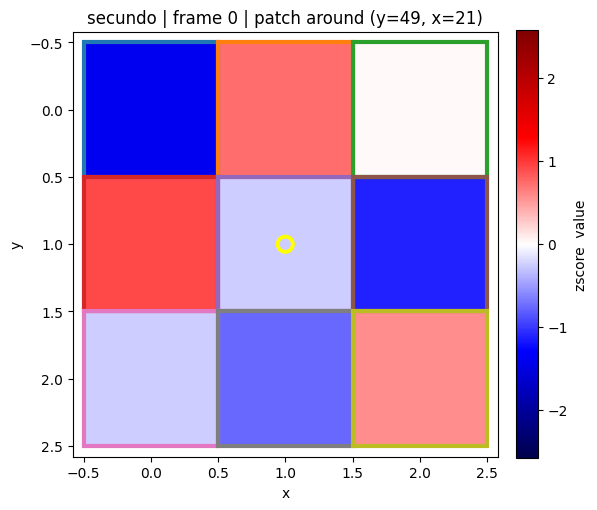

In [ ]:
# center pixel as (y, x)
center_pixel = (49, 21)
cy, cx = center_pixel
r = 1  # 3x3 patch
sample_frame_idx = 0
frame = mean_frames[sample_frame_idx]
H, W = frame.shape

# patch bounds
y0, y1 = max(0, cy - r), min(H, cy + r + 1)
x0, x1 = max(0, cx - r), min(W, cx + r + 1)
patch = frame[y0:y1, x0:x1]
h, w = patch.shape

abs_lim = float(np.nanpercentile(np.abs(frame), 99.0))
if not np.isfinite(abs_lim) or abs_lim <= 1e-8:
    abs_lim = 1.0
norm = TwoSlopeNorm(vmin=-abs_lim, vcenter=0.0, vmax=abs_lim)

fig, ax = plt.subplots(figsize=(6, 6))
im = ax.imshow(patch, cmap="seismic", norm=norm, interpolation="nearest")
pad = 0.08  # small axis buffer so outer borders are visible
ax.set_xlim(-0.5 - pad, w - 0.5 + pad)
ax.set_ylim(h - 0.5 + pad, -0.5 - pad)

# thicker per-pixel outlines, colored to match trace colors
for iy in range(h):
    for ix in range(w):
        global_coord = (y0 + iy, x0 + ix)  # (y, x) in full frame
        edge = coord_to_color.get(global_coord, "white")
        ax.add_patch(
            Rectangle(
                (ix - 0.5, iy - 0.5), 1, 1, fill=False, edgecolor=edge, linewidth=3.0
            )
        )

ax.scatter(
    cx - x0,
    cy - y0,
    s=120,
    facecolors="none",
    edgecolors="yellow",
    linewidths=2.8,
    zorder=5,
)

cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label(f"{data_mode}  value", rotation=90)

ax.set_title(
    f"{sample_subject} | frame {sample_frame_idx} | patch around (y={cy}, x={cx})"
)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_aspect("equal")
plt.show()

#####  timecourse plot (multiple pixel traces in the patch over time)

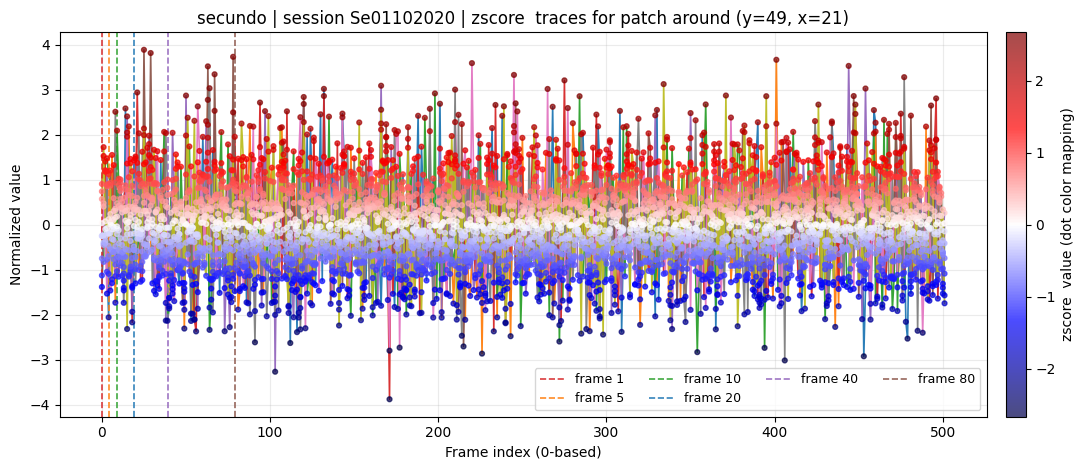

In [ ]:
all_patch_values = np.concatenate(
    [mean_frames[:, y, x] for (y, x) in pixel_coordinates]
)
abs_lim = float(np.nanpercentile(np.abs(all_patch_values), 99.0))
if not np.isfinite(abs_lim) or abs_lim <= 1e-8:
    abs_lim = 1.0
norm = TwoSlopeNorm(vmin=-abs_lim, vcenter=0.0, vmax=abs_lim)

fig, ax = plt.subplots(figsize=(11, 4.8))
for pixel in pixel_coordinates:
    y, x = pixel
    pixel_ts = mean_frames[:, y, x]
    t = np.arange(T)

    trace_color = coord_to_color[pixel]
    ax.plot(t, pixel_ts, color=trace_color, linewidth=1.2, alpha=0.95, zorder=2)
    sc = ax.scatter(
        t, pixel_ts, c=pixel_ts, cmap="seismic", norm=norm, s=12, alpha=0.70, zorder=3
    )

marker_frames_1based = [1, 5, 10, 20, 40, 80]
marker_colors = [
    "tab:red",
    "tab:orange",
    "tab:green",
    "tab:blue",
    "tab:purple",
    "tab:brown",
]

for f, c in zip(marker_frames_1based, marker_colors, strict=False):
    idxf = f - 1  # convert to 0-based index for plotting
    if 0 <= idxf < T:
        ax.axvline(
            idxf, linestyle="--", linewidth=1.2, color=c, alpha=0.9, label=f"frame {f}"
        )

cbar = fig.colorbar(sc, ax=ax, fraction=0.04, pad=0.02)
cbar.set_label(f"{data_mode}  value (dot color mapping)", rotation=90)

ax.set_title(
    f"{sample_subject} | session {sample_session['session_id']} | {data_mode}  traces for patch around (y={center_pixel[0]}, x={center_pixel[1]})"
)
ax.set_xlabel("Frame index (0-based)")
ax.set_ylabel("Normalized value")
ax.grid(alpha=0.25)
ax.legend(ncol=4, fontsize=9)
fig.tight_layout()
# pixel_trace_fig = fig
plt.show()

##### timecourse video across frames (saved as MP4 or GIF)

In [12]:
# center pixel as (y, x)
center_pixel = (49, 21)
cy, cx = center_pixel
r = 1  # 3x3 patch

# patch bounds
y0, y1 = max(0, cy - r), min(H, cy + r + 1)
x0, x1 = max(0, cx - r), min(W, cx + r + 1)
patch = frame[y0:y1, x0:x1]
h, w = patch.shape

patched_frames = mean_frames[:, y0:y1, x0:x1]  # (T, h, w)

sample_frame_idx = 0
frame = mean_frames[sample_frame_idx]
H, W = frame.shape

ref_frame = mean_frames[sample_frame_idx]
abs_lim = float(np.percentile(np.abs(ref_frame), 99.0))
if abs_lim <= 1e-8:
    abs_lim = 1.0
norm = TwoSlopeNorm(vmin=-abs_lim, vcenter=0.0, vmax=abs_lim)


fig, ax = plt.subplots(figsize=(6, 6))
im = ax.imshow(patch, cmap="seismic", norm=norm)
cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label(f"{data_mode}  value", rotation=90)

title = ax.set_title(
    f"{sample_subject} | session {sample_session['session_id']} |patch | {data_mode}  frame 0"
)
ax.set_xlabel("x")
ax.set_ylabel("y")

T = patched_frames.shape[0]
image_data = patched_frames

ani = animation.FuncAnimation(
    fig, update_frame_in_video, frames=T, interval=100, blit=False, repeat=False
)

out_dir = Path("derivatives") / "videos"
out_dir.mkdir(parents=True, exist_ok=True)
base = f"{sample_subject}_session-{sample_session['session_id']}_{data_mode} _patch"

mp4_path = out_dir / f"{base}.mp4"
gif_path = out_dir / f"{base}.gif"

saved = None
try:
    writer = animation.FFMpegWriter(fps=10, bitrate=1800)
    ani.save(str(mp4_path), writer=writer, dpi=150)
    saved = mp4_path
except FileNotFoundError:
    print("ffmpeg not found; saving GIF instead...")
    writer = animation.PillowWriter(fps=10)
    ani.save(str(gif_path), writer=writer, dpi=120)
    saved = gif_path

plt.close(fig)
print(f"Saved: {saved}")

ffmpeg not found; saving GIF instead...
Saved: derivatives\videos\secundo_session-Se01102020_zscore _patch.gif
